In [28]:
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import numpy as np
import seaborn as sb

Make it easy to reset the notebook

In [2]:
if 'ei38-teaching' not in bd.projects:
    bw2io.restore_project_directory("/srv/data/projects/ecoinvent38.tar.gz")

In [4]:
bd.projects.set_current('ei38-teaching')

In [5]:
assert 'ei 3.8 cutoff' in bd.databases
ei = bd.Database('ei 3.8 cutoff')

In [20]:
ipcc = ('IPCC 2013', 'climate change', 'GWP 100a')

In [12]:
ng = [act 
      for act in ei
      if 'natural gas' in act['name']
      and 'market' in act['name']
      and act['location'] == 'DE'
      and act['unit'] == 'cubic meter'
     ]
assert len(ng) == 1
ng = ng[0]

Make sure we have Russian natural gas

In [16]:
{exc.input['location'] for exc in ng.technosphere()}

{'DE', 'Europe without Switzerland'}

That isn't what I expected... let's look at the inputs

In [17]:
list(ng.technosphere())

[Exchange: 0.00294840000000001 kilowatt hour 'market for electricity, medium voltage' (kilowatt hour, DE, None) to 'market for natural gas, high pressure' (cubic meter, DE, None)>,
 Exchange: 0.0618735000000002 megajoule 'market for heat, district or industrial, natural gas' (megajoule, Europe without Switzerland, None) to 'market for natural gas, high pressure' (cubic meter, DE, None)>,
 Exchange: 0.115400000000003 cubic meter 'market for natural gas, high pressure' (cubic meter, DE, None) to 'market for natural gas, high pressure' (cubic meter, DE, None)>,
 Exchange: 0.608400000000002 ton kilometer 'transport, pipeline, long distance, natural gas' (ton kilometer, DE, None) to 'market for natural gas, high pressure' (cubic meter, DE, None)>,
 Exchange: 5.65500000000001e-08 kilometer 'pipeline construction, natural gas, high pressure distribution network' (kilometer, Europe without Switzerland, None) to 'market for natural gas, high pressure' (cubic meter, DE, None)>,
 Exchange: 0.0822

ecoinvent, ecoinvent... we need `natural gas, high pressure, import from RU`.

Let's get the values we will compare against.

In [25]:
mc = bc.MonteCarloLCA({ng: 1}, ipcc)

In [27]:
results = np.array([next(mc) for _ in range(100)])

<AxesSubplot: ylabel='Count'>

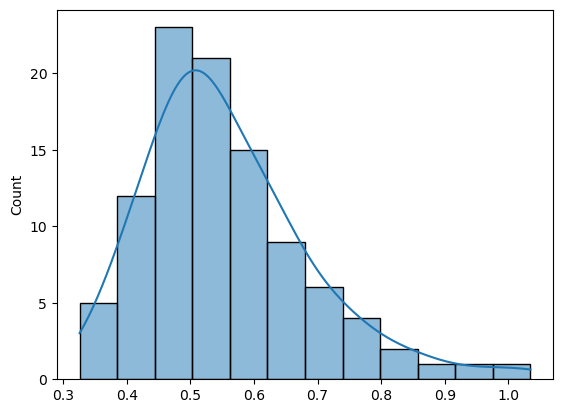

In [30]:
sb.histplot(results, kde=True)

Create new database for our modified process

In [31]:
ndb = bd.Database("2022")
ndb.register()

Create a copy in our new database:

In [34]:
other_ng = ng.copy(code=ng['code'], database=ndb.name)

Before we can subtract the Russian gas, we need to figure out how much gas is used to produce one cubic metre. Let's sum the exchanges:

In [39]:
ng['reference product']

'natural gas, high pressure'

In [42]:
sum(exc['amount'] 
    for exc in other_ng.technosphere() 
    if exc.input != exc.output 
    and exc.input['reference product'] == 'natural gas, high pressure'
   )

0.9999999999999999

That is close enough that we will just use 1. Let's remove the Russian gas:

In [44]:
for exc in other_ng.technosphere():
    if exc.input['name'] == 'natural gas, high pressure, import from RU':
        print("Found it")
        subtracted_amount = exc['amount']
        exc['amount'] = 0
        exc.save()
        
print(subtracted_amount)

Found it
0.381626633559608


In [45]:
normalization = 1 / (1 - subtracted_amount)

Run this once to make sure we won't break things.

In [47]:
for exc in other_ng.technosphere():
    if exc.input != exc.output and exc.input['reference product'] == 'natural gas, high pressure':
        print("Changing {}".format(exc))
        print("Amount from {} to {}".format(exc['amount'], exc['amount'] * normalization))

Changing Exchange: 0.0822377569943268 cubic meter 'natural gas production' (cubic meter, DE, None) to 'market for natural gas, high pressure' (cubic meter, DE, None)>
Amount from 0.0822377569943268 to 0.13299045763843403
Changing Exchange: 0.214664981377279 cubic meter 'natural gas, high pressure, import from NL' (cubic meter, DE, None) to 'market for natural gas, high pressure' (cubic meter, DE, None)>
Amount from 0.214664981377279 to 0.34714461040419275
Changing Exchange: 0.321470628068786 cubic meter 'natural gas, high pressure, import from NO' (cubic meter, DE, None) to 'market for natural gas, high pressure' (cubic meter, DE, None)>
Amount from 0.321470628068786 to 0.5198649319573729
Changing Exchange: 0 cubic meter 'natural gas, high pressure, import from RU' (cubic meter, DE, None) to 'market for natural gas, high pressure' (cubic meter, DE, None)>
Amount from 0 to 0.0


OK, let's go forward.

In [48]:
for exc in other_ng.technosphere():
    if exc.input != exc.output and exc.input['reference product'] == 'natural gas, high pressure':
        exc['amount'] = exc['amount'] * normalization
        exc.save()

We can calculate the GWP of this new mix:

<AxesSubplot: ylabel='Count'>

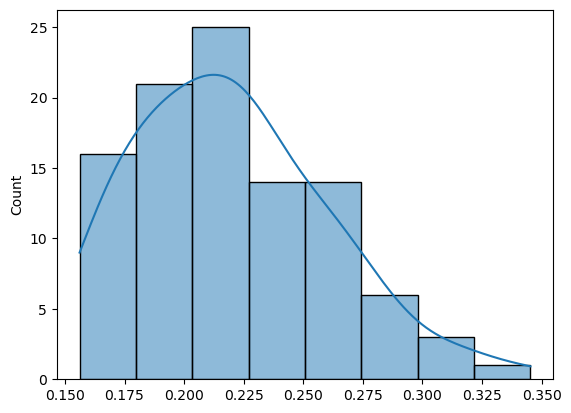

In [51]:
other_mc = bc.MonteCarloLCA({other_ng: 1}, ipcc)
results_other_ng = np.array([next(other_mc) for _ in range(100)])
sb.histplot(results_other_ng, kde=True)

Now we need to redirect the consumers of this gas mix. We will switch from A to B:

In [49]:
print("A", ng.key, "B", other_ng.key)

A ('ei 3.8 cutoff', '440b97bab2e55d297856f25e05391d0b') B ('2022', '440b97bab2e55d297856f25e05391d0b')


In [52]:
for exc in ng.upstream():
    if exc.input != exc.output:  # Skip production exchanges
        exc.input = other_ng
        exc.save()